# **AutoEncoders & Variational AutoEncoders**

<img src="https://pureai.com/articles/2020/05/07/~/media/ecg/pureai/images/2020/05/autoencoders3.asxh" width=70%>


## Chapter 1. AutoEncoders

The idea of AutoEncoder is really simple.<br>
We get data, pass it through encoder (stack of layers) to map it to lower dimension.<br>
Then from this lower dimension we reconstruct the passed data using MSE to compare them and measure quality.<br>
Sounds great, sounds good!<br>
AutoEncoder can be visualized as follows:<br>

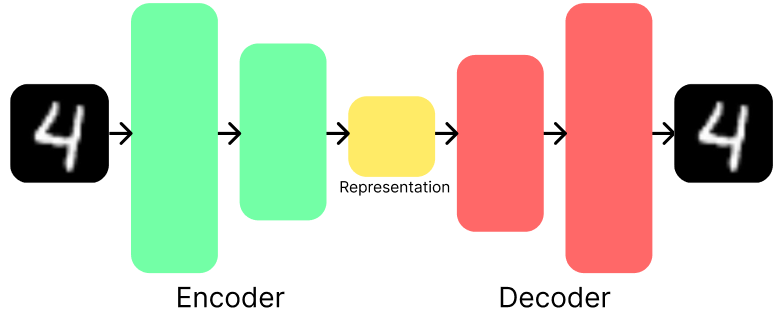

<br>

Finally, for image generation we pass random coordinates in this learned space and recreate image from coordinates.<br>
In training process AutoEncoder is learning how to organise data and how to decode from there.<br>
Let's implement autoencoder on MNIST dataset using both Linear layers and Convolutional layers!

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Load the data

data = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
dataloader = DataLoader(data, batch_size=16, shuffle=True, pin_memory=True)
dataloader

### Let's start with a simple Feed-Forward nets

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128)
    )

  def forward(self, input):
    return self.encoder(input)

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784)
    )

  def forward(self, input):
    return self.decoder(input)

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    encoder_out = self.encoder(input)
    decoder_out = self.decoder(encoder_out)
    return decoder_out

In [ ]:
# Training Loop!

epochs = 5

encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(autoencoder.parameters(), lr=lr)

Epoch: 1 | 107.88373565673828


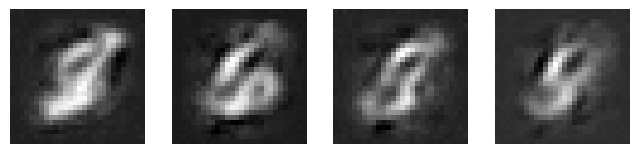

Epoch: 2 | 61.671897888183594


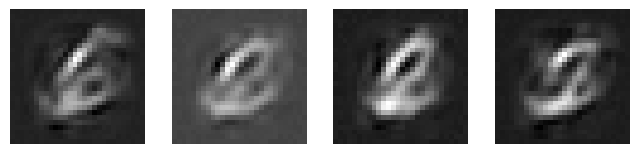

Epoch: 3 | 52.60992431640625


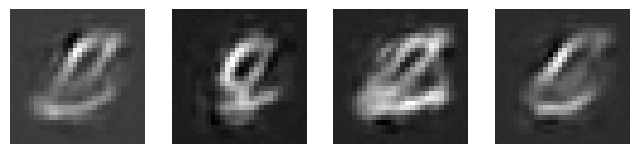

Epoch: 4 | 47.418357849121094


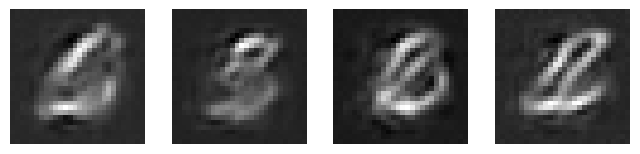

Epoch: 5 | 43.781883239746094


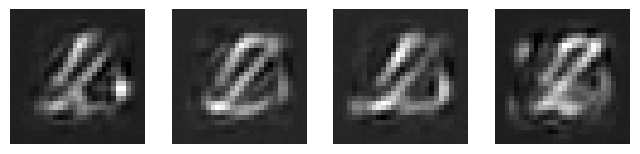

In [ ]:
for epoch in range(epochs):
  autoencoder.train()
  epoch_loss = 0
  for img, _ in dataloader:
    img = img.to(device)
    img = img.view(-1, 1, 784)  # Flatten
    reconstruction = autoencoder(img)
    batch_loss = loss_fn(reconstruction, img)
    epoch_loss += batch_loss

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | {epoch_loss.item()}")

  # Generate Images from noise
  autoencoder.eval()
  with torch.inference_mode():
    random_ = torch.rand((4, 1, 128), device=device)
    reconstruction = decoder(random_).cpu().view(4, 28, 28, 1)
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img, cmap="gray")
    plt.show()

Well...<br>
It's definitely something simmilar to MNIST digits, but it's really messy...<br>
Uhm... Maybe CNNs can Help!

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2),  # 32x13x13
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2),  # 6x6x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=2),  # 8x4x4
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 2, kernel_size=3, stride=2, padding=1),  # 2x2x2
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.encoder(x)
        batch_size = x.shape[0]
        return x.view(batch_size, 8, 1, 1)

In [ ]:
class CNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2),
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
class CNNAutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    encoder_out = self.encoder(input)
    decoder_out = self.decoder(encoder_out)
    return decoder_out

In [ ]:
# Training Loop!

epochs = 5

cnn_encoder = CNNEncoder().to(device)
cnn_decoder = CNNDecoder().to(device)
cnn_autoencoder = CNNAutoEncoder(cnn_encoder, cnn_decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(cnn_autoencoder.parameters(), lr=lr)

Epoch: 1 | 145.2665252685547


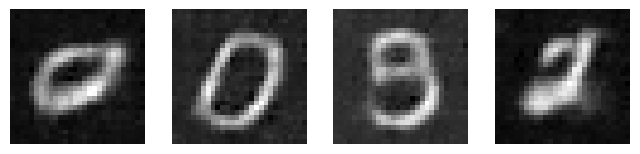

Epoch: 2 | 114.14248657226562


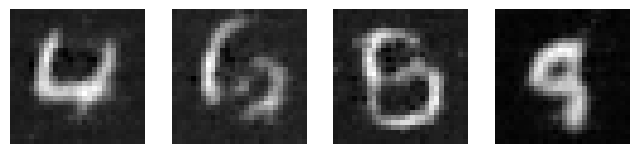

Epoch: 3 | 108.46180725097656


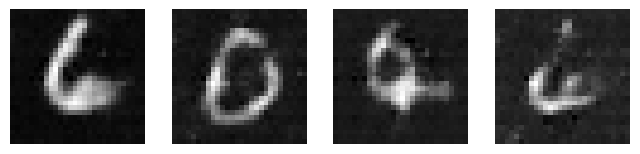

Epoch: 4 | 105.0889663696289


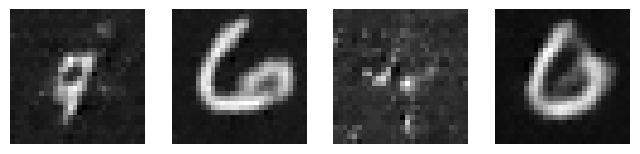

Epoch: 5 | 102.6886215209961


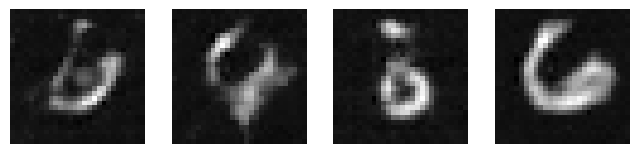

In [ ]:
for epoch in range(epochs):
  cnn_autoencoder.train()
  epoch_loss = 0
  for img, _ in dataloader:
    img = img.to(device)
    reconstruction = cnn_autoencoder(img)
    batch_loss = loss_fn(reconstruction, img)
    epoch_loss += batch_loss

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | {epoch_loss.item()}")

  # Generate Images from noise
  cnn_autoencoder.eval()
  with torch.inference_mode():
    random_ = torch.rand((4, 8, 1, 1), device=device)
    reconstruction = cnn_decoder(random_).cpu()
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

Okay, CNN definitely performs better, but to be honest it's more powerful (more layers and features) then Feed-Forward Net.<br>
Let's run full encoder-decoder cycle.

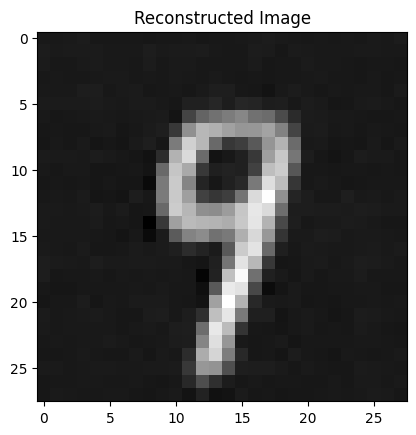

In [ ]:
cnn_autoencoder.eval()
for img, _ in dataloader:
    img = img.to(device)
    sample = img[0].unsqueeze(0)
    reconstruction = cnn_autoencoder(sample)
    break

plt.title("Reconstructed Image")
plt.imshow(reconstruction.cpu().detach().squeeze(0).permute(1, 2, 0).numpy(), cmap="grey");

Hmm... Well it appears that our Decoder is powerful enough.<br>
This means that there's a problem with our input we pass in.<br>
As I mentioned earlier AutoEncoder organizes samples in latent space, but this space is not structured enough, with many gaps.<br>
Selecting coordinate we can randomly land somewhere between 6 and 8 and our decoder will generate mix of 6 and 8 resulting in ugly results.<br>
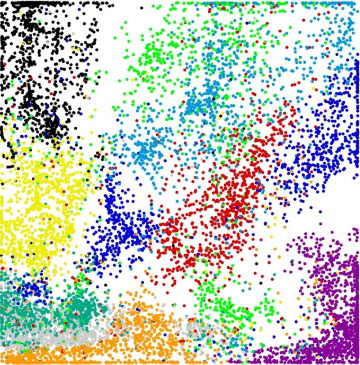


## Chapter 2. Variational AutoEncoders.
Variational AutoEncoders organize space in a better way.<br>
VAE represents latent space as a normal distribution learning mean and variance for it.<br>
This way, it stores only useful information and when sampling from it we'll fall only in meaningful spots.<br>
Point sampling now happens as:<br>
$z = \mu + \sigma \cdot \epsilon$, where $\epsilon$ - random noise vector.<br>
To keep distribution as close to normal as possible we use KL Divergence adding it to reconstruction loss (MSE).<br>

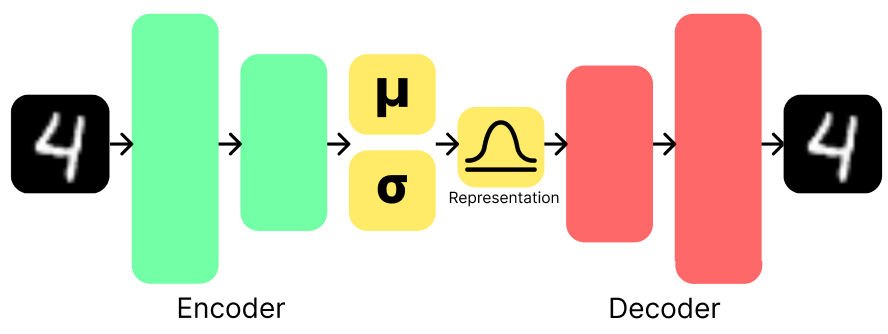

In [ ]:
class CNNVAEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2),         # 32x13x13
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2),        # 16x6x6
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=2),  # 8x4x4
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 2, kernel_size=3, stride=2, padding=1),   # 2x2x2
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(2 * 2 * 2, 8)
        self.fc_logvar = nn.Linear(2 * 2 * 2, 8)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [ ]:
class CNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(8, 8)  # z to 8 dim latent
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid()  # To keep output in [0,1]
        )

    def forward(self, z):
        z = self.fc(z).view(-1, 8, 1, 1)
        return self.decoder(z)

In [ ]:
class CNNVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [ ]:
def vae_loss_function(reconstructed, original, mu, logvar):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + kl, recon_loss.item(), kl.item()


cnn_encoder = CNNVAEEncoder().to(device)
cnn_decoder = CNNDecoder().to(device)
vae = CNNVAE(cnn_encoder, cnn_decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    vae.train()
    epoch_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0

    for img, _ in dataloader:
        img = img.to(device)

        optimizer.zero_grad()
        output, mu, logvar = vae(img)

        loss, recon, kl = vae_loss_function(output, img, mu, logvar)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_recon += recon
        total_kl += kl

    print(f"Epoch {epoch+1}: Total Loss = {epoch_loss:.4f}, Recon Loss = {total_recon:.4f}, KL = {total_kl:.4f}")

    vae.eval()
    with torch.no_grad():
        z = torch.randn((4, 8)).to(device)
        generated = cnn_decoder(z).cpu()
        plt.figure(figsize=(8, 4))
        for i, img in enumerate(generated):
            plt.subplot(1, 4, i+1)
            plt.axis('off')
            plt.imshow(img.squeeze(), cmap='gray')
        plt.show()